In [1]:
from IPython import get_ipython
from IPython.display import display

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torch.utils.data import Dataset
from google.colab import files

from PIL import Image


files.upload()

# Kaggle 데이터 다운로드
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 다운로드 및 압축 해제
!kaggle competitions download -c aptos2019-blindness-detection -p ./data
!unzip -qo ./data/aptos2019-blindness-detection.zip -d ./data/aptos2019

Saving kaggle.json to kaggle.json
100% 9.50G/9.51G [01:05<00:00, 133MB/s]
100% 9.51G/9.51G [01:05<00:00, 156MB/s]


In [2]:
class APTOSDataset(Dataset):
        def __init__(self, dataframe, img_dir, transform=None):
            self.dataframe = dataframe
            self.img_dir = img_dir
            self.transform = transform

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            row = self.dataframe.iloc[idx]
            img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
            label = int(row['diagnosis'])
            if not os.path.exists(img_path):
              raise FileNotFoundError(f"이미지 파일이 존재하지 않습니다: {img_path}")
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label

In [3]:
def load_and_preprocess_data(data_path):
    train_csv = os.path.join(data_path, "train.csv")
    train_images_dir = os.path.join(data_path, "train_images")

    if not os.path.exists(train_csv):
        raise FileNotFoundError(f"The file {train_csv} does not exist. Please ensure the dataset was downloaded and extracted correctly.")
    # 데이터 로드
    df = pd.read_csv(train_csv)
    df['diagnosis'] = df['diagnosis'].astype(str)  # 레이블을 문자열로 변환

    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['diagnosis'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['diagnosis'], random_state=42)

    return train_df, val_df, test_df, train_images_dir

data_path = "./data/aptos2019"
train_df, val_df, test_df, train_images_dir = load_and_preprocess_data(data_path)

In [4]:
!pip install torchinfo
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [6]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [7]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [9]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [10]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [11]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [12]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [13]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [15]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=5):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [16]:
ResNet50 = timm.create_model('resnet50', pretrained=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [17]:
for param in ResNet50.parameters():
    param.requires_grad = False

ResNet50.fc = nn.Identity()

In [18]:
class LauncherModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = ResNet50
        self.upsample1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(8, 3, kernel_size=4, stride=4, padding=0)

        self.levit = LevitDistilled()

    def forward(self, x):
        x = self.resnet(x)  # (32, 2048)
        x = x.view(x.size(0), 32, 8, 8)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.levit(x)
        return x

In [19]:
model = LauncherModel()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 0.001
num_epochs = 50

LauncherModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [20]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                       Output Shape              Param #
LauncherModel                                                [32, 5]                   --
├─ResNet: 1-1                                                [32, 2048]                --
│    └─Conv2d: 2-1                                           [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                                      [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                                             [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                                        [32, 64, 56, 56]          --
│    └─Sequential: 2-5                                       [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                                  [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                                  [32, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                                  [32, 256, 56, 

In [21]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                       Output Shape              Param #
LauncherModel                                                [32, 5]                   --
├─ResNet: 1-1                                                [32, 2048]                --
│    └─conv1.weight                                                                    ├─9,408
│    └─bn1.weight                                                                      ├─64
│    └─bn1.bias                                                                        ├─64
│    └─layer1.0.conv1.weight                                                           ├─4,096
│    └─layer1.0.bn1.weight                                                             ├─64
│    └─layer1.0.bn1.bias                                                               ├─64
│    └─layer1.0.conv2.weight                                                           ├─36,864
│    └─layer1.0.bn2.weight                                             

In [22]:
data_dir = "./data/aptos2019"
train_csv = os.path.join(data_dir, "train.csv")
df = pd.read_csv(train_csv)

#클래스 균형 맞추기
# def balance_classes(df):
#     max_count = df['diagnosis'].value_counts().max()
#     balanced_df = pd.DataFrame()
#     for class_label, group in df.groupby('diagnosis'):
#         balanced_group = resample(group, replace=True, n_samples=max_count, random_state=42)
#         balanced_df = pd.concat([balanced_df, balanced_group])
#     return balanced_df

# balanced_df = balance_classes(df)


def split_dataset(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    train_df, temp_df = train_test_split(
        df,
        test_size=(1 - train_ratio),
        stratify=df['diagnosis'],
        random_state=42
    )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(test_ratio / (val_ratio + test_ratio)),
        stratify=temp_df['diagnosis'],
        random_state=42
    )
    return train_df, val_df, test_df

train_df, val_df, test_df = split_dataset(df)

# 분할된 데이터 저장
train_df.to_csv(os.path.join(data_dir, "train_balanced.csv"), index=False)
val_df.to_csv(os.path.join(data_dir, "val_balanced.csv"), index=False)
test_df.to_csv(os.path.join(data_dir, "test_balanced.csv"), index=False)

# 클래스별 분포 출력
print("Balanced Train 세트 클래스 분포:")
print(train_df['diagnosis'].value_counts().sort_index())

print("\nBalanced Validation 세트 클래스 분포:")
print(val_df['diagnosis'].value_counts().sort_index())

print("\nBalanced Test 세트 클래스 분포:")
print(test_df['diagnosis'].value_counts().sort_index())

Balanced Train 세트 클래스 분포:
diagnosis
0    1263
1     259
2     699
3     135
4     207
Name: count, dtype: int64

Balanced Validation 세트 클래스 분포:
diagnosis
0    271
1     55
2    150
3     29
4     44
Name: count, dtype: int64

Balanced Test 세트 클래스 분포:
diagnosis
0    271
1     56
2    150
3     29
4     44
Name: count, dtype: int64


In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
train_dataset = APTOSDataset(train_df, train_images_dir, transform=transform)
val_dataset = APTOSDataset(val_df, train_images_dir, transform=transform)
test_dataset = APTOSDataset(test_df, train_images_dir, transform=transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 2563
Validation set size: 549
Test set size: 550


In [26]:
def show_images(dataset, num_images=5):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

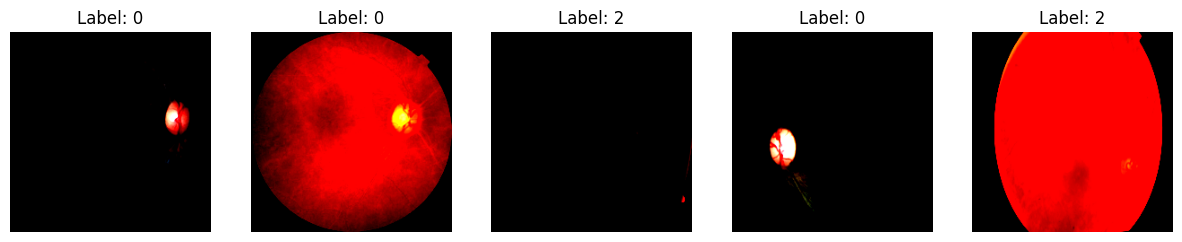

In [27]:
show_images(train_dataset, num_images=5)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [30]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(accuracy)
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [31]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    if phase == "Validation":
        val_loss.append(epoch_loss)
        val_acc.append(accuracy)
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [32]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [33]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 1.2619, Train Accuracy: 54.74%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 4.3592, Validation Accuracy: 27.50%

Epoch 2/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.9315, Train Accuracy: 67.26%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.8767, Validation Accuracy: 69.95%

Epoch 3/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.9171, Train Accuracy: 68.16%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.8720, Validation Accuracy: 69.58%

Epoch 4/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.7939, Train Accuracy: 70.43%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7580, Validation Accuracy: 72.50%

Epoch 5/50


Training: 100%|██████████| 81/81 [01:25<00:00,  1.05s/it]


Train Loss: 0.7437, Train Accuracy: 72.18%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8318, Validation Accuracy: 68.12%

Epoch 6/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Train Loss: 0.7569, Train Accuracy: 71.13%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7246, Validation Accuracy: 74.50%

Epoch 7/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.7751, Train Accuracy: 71.75%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7264, Validation Accuracy: 72.50%

Epoch 8/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6975, Train Accuracy: 73.55%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8640, Validation Accuracy: 67.40%

Epoch 9/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.7126, Train Accuracy: 74.76%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7410, Validation Accuracy: 71.58%

Epoch 10/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6994, Train Accuracy: 73.43%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7830, Validation Accuracy: 71.95%

Epoch 11/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6712, Train Accuracy: 75.22%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


Validation Loss: 0.7301, Validation Accuracy: 72.68%

Epoch 12/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6661, Train Accuracy: 75.61%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7762, Validation Accuracy: 71.77%

Epoch 13/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.6764, Train Accuracy: 74.60%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7072, Validation Accuracy: 73.95%

Epoch 14/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6270, Train Accuracy: 76.00%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7796, Validation Accuracy: 70.31%

Epoch 15/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6102, Train Accuracy: 76.43%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6838, Validation Accuracy: 73.95%

Epoch 16/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.04s/it]


Train Loss: 0.5810, Train Accuracy: 78.03%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 1.5922, Validation Accuracy: 59.20%

Epoch 17/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.05s/it]


Train Loss: 0.7518, Train Accuracy: 72.34%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


Validation Loss: 0.7748, Validation Accuracy: 66.85%

Epoch 18/50


Training: 100%|██████████| 81/81 [01:25<00:00,  1.06s/it]


Train Loss: 0.6547, Train Accuracy: 74.68%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6495, Validation Accuracy: 74.68%

Epoch 19/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6022, Train Accuracy: 75.97%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6827, Validation Accuracy: 73.95%

Epoch 20/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.5926, Train Accuracy: 77.02%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6958, Validation Accuracy: 72.86%

Epoch 21/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.5642, Train Accuracy: 77.84%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6387, Validation Accuracy: 75.23%

Epoch 22/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.5503, Train Accuracy: 78.19%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7046, Validation Accuracy: 74.13%

Epoch 23/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5652, Train Accuracy: 78.42%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6730, Validation Accuracy: 73.77%

Epoch 24/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.05s/it]


Train Loss: 0.5535, Train Accuracy: 79.32%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6797, Validation Accuracy: 73.59%

Epoch 25/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5248, Train Accuracy: 79.71%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6926, Validation Accuracy: 74.50%

Epoch 26/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5440, Train Accuracy: 79.20%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7092, Validation Accuracy: 73.41%

Epoch 27/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.04s/it]


Train Loss: 0.5481, Train Accuracy: 78.27%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7043, Validation Accuracy: 74.13%

Epoch 28/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Train Loss: 0.5083, Train Accuracy: 79.91%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7987, Validation Accuracy: 72.31%

Epoch 29/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5549, Train Accuracy: 80.57%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 1.9896, Validation Accuracy: 66.12%

Epoch 30/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.8599, Train Accuracy: 68.16%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8570, Validation Accuracy: 69.76%

Epoch 31/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.7153, Train Accuracy: 72.88%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7655, Validation Accuracy: 72.13%

Epoch 32/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.04s/it]


Train Loss: 0.6722, Train Accuracy: 74.40%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7909, Validation Accuracy: 72.31%

Epoch 33/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6578, Train Accuracy: 75.26%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6995, Validation Accuracy: 72.68%

Epoch 34/50


Training: 100%|██████████| 81/81 [01:25<00:00,  1.06s/it]


Train Loss: 0.6116, Train Accuracy: 76.24%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7233, Validation Accuracy: 72.86%

Epoch 35/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.04s/it]


Train Loss: 0.5965, Train Accuracy: 76.59%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6787, Validation Accuracy: 74.50%

Epoch 36/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6004, Train Accuracy: 76.71%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6943, Validation Accuracy: 74.13%

Epoch 37/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5680, Train Accuracy: 77.72%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6624, Validation Accuracy: 75.77%

Epoch 38/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5589, Train Accuracy: 78.81%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7612, Validation Accuracy: 70.49%

Epoch 39/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6062, Train Accuracy: 76.79%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6943, Validation Accuracy: 73.41%

Epoch 40/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5696, Train Accuracy: 79.05%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7575, Validation Accuracy: 73.59%

Epoch 41/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.05s/it]


Train Loss: 0.5635, Train Accuracy: 78.42%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7446, Validation Accuracy: 74.32%

Epoch 42/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.04s/it]


Train Loss: 0.6739, Train Accuracy: 75.61%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7595, Validation Accuracy: 72.86%

Epoch 43/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.05s/it]


Train Loss: 0.5569, Train Accuracy: 78.27%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7648, Validation Accuracy: 75.59%

Epoch 44/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.5370, Train Accuracy: 79.44%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6536, Validation Accuracy: 76.87%

Epoch 45/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.04s/it]


Train Loss: 0.5410, Train Accuracy: 79.95%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.7231, Validation Accuracy: 72.50%

Epoch 46/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5340, Train Accuracy: 80.14%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


Validation Loss: 0.6820, Validation Accuracy: 73.77%

Epoch 47/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5194, Train Accuracy: 80.02%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6703, Validation Accuracy: 75.41%

Epoch 48/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5040, Train Accuracy: 80.14%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6918, Validation Accuracy: 73.41%

Epoch 49/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5125, Train Accuracy: 79.71%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


Validation Loss: 0.7540, Validation Accuracy: 73.95%

Epoch 50/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.4654, Train Accuracy: 83.18%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]

Validation Loss: 0.6947, Validation Accuracy: 71.22%


In [34]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]

Test Loss: 0.7557, Test Accuracy: 72.73%


In [35]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 18
Average Time: 15.95 ms
Standard Deviation: 1.87 ms
Maximum Time: 23.44 ms
Minimum Time: 14.20 ms


In [36]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::convolution         1.58%     436.358us        35.21%       9.704ms     156.511us       0.000us         0.00%       7.244ms     116.846us            62  
                                     aten::_convolution         9.94%       2.739ms        33.63%       9.267ms     149.473us       0.000us         0.00%       7.244ms     116.846us            62  
         

In [37]:
save_path = "L_HoViT_APTOS2019.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to L_HoViT_APTOS2019.pth


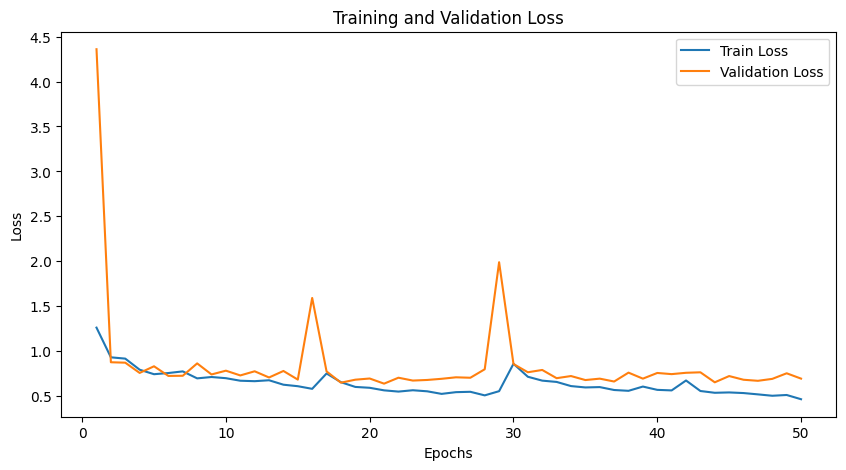

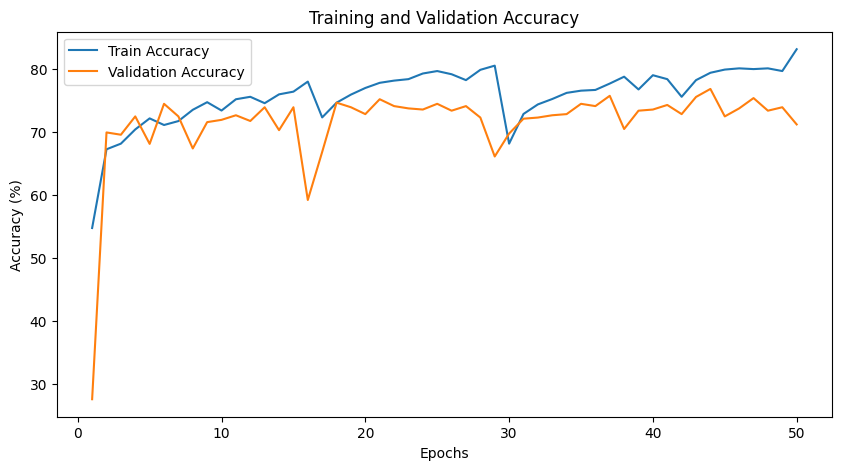

In [38]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss)+1)


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()